<a href="https://colab.research.google.com/github/Narc17/Academic-article-classification-with-bert/blob/main/src_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Random seed

In [ ]:
import torch
torch.manual_seed(42)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8146484914751722437, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13611128505492714209
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6048193520247411189
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11085873152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 108530224703114898
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 6.8MB/s 
     |████████████████████████████████| 92kB 34.2MB/s 
     |████████████████████████████████| 645kB 47.5MB/s 


In [ ]:
# test for installed bert package.
import pytorch_pretrained_bert

In [ ]:
drive_path = '/content/drive/My Drive/SDML/bert/'

# Take a  view of dataset

In [ ]:
import pandas as pd

dataset = pd.read_csv(drive_path + 'data/task2_trainset.csv', dtype=str)
dataset.head()
dataset.shape

(7000, 7)

# Data processing

In [ ]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.head()

In [ ]:
dataset.to_csv(drive_path + 'src/dataset.csv', index=False)

In [ ]:
testset = pd.read_csv(drive_path + '/data/task2_public_testset.csv', dtype=str)
testset.drop('Title',axis=1,inplace=True)
testset.drop('Categories',axis=1,inplace=True)
testset.drop('Created Date',axis=1, inplace=True)
testset.drop('Authors',axis=1,inplace=True)

In [ ]:
testset.to_csv(drive_path + 'src/testset.csv',index=False)

#Bert:

##Tokenizing & Embedding:



####New tokenizing (adding noise)

In [ ]:
from pytorch_pretrained_bert import BertTokenizer
import pandas as pd
import math
import random

MAX_SEQ_LENGTH = 256

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot

def collect_words_bert_para_with_noise(data_path, type="Train", add_noise=False, noise_rate=0.15):
    df = pd.read_csv(data_path, dtype=str)

    # add [CLS] and [SEP] tags on abstract paragraph: list["[CLS]", every sentences in abstract, "[SEP]"]
    input_texts = []
    labels = []
    for i in df.iterrows():
        replaced_texts = i[1]['Abstract'].replace('$$$', ' ')
        input_texts.append(replaced_texts)
        # abstracting labels in onehot representation.
        if type == "Train":
            labels.append(label_to_onehot(i[1]['Task 2']))

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    # tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)    
    
    tokens = []
    input_ids = []
    atte_mask_list = []
    for text in input_texts:   
      token_a = tokenizer.tokenize(text)

      # truncating
      if len(token_a) > MAX_SEQ_LENGTH - 2: # -1 from [CLS] and [SEP] tag each.
          token_a = token_a[:(MAX_SEQ_LENGTH - 2)]

      if add_noise:
          # adding 15% noise in 1 sentence.
          noise_num = math.floor(len(token_a) * noise_rate) 
          noise = random.sample(range(len(token_a)), noise_num)

          for i in range(noise_num):
              token_a[noise[i]] = "[UNK]"

      # add [CLS] and [SEP] at the beginning and the end on each input paragraph respectively.
      tokens += [["[CLS]"] + token_a + ["[SEP]"]]
    
    # convert tokens into embeddings, then set up its attention mask and pad it into MAX_SEQ_LENGTH.
    for token in tokens:
      embedded_token = tokenizer.convert_tokens_to_ids(token)
      attention_mask = [1] * len(embedded_token)
      padding = [0] * (MAX_SEQ_LENGTH - len(embedded_token))
      embedded_token += padding
      attention_mask += padding
      input_ids += [embedded_token]
      atte_mask_list += [attention_mask]

    return input_ids, labels, atte_mask_list




####Tokenizing inputs

In [ ]:
bert_embedder, labels, attention_mask_list = collect_words_bert_para_with_noise(drive_path + 'src/dataset.csv', type="Train")
bert_embedder_test, _, attention_mask_list_test = collect_words_bert_para_with_noise(drive_path + 'src/testset.csv', type="Test")

###Save/read embedded data

In [ ]:
import pickle

drive_path = '/content/drive/My Drive/SDML/bert/'

# trainset
with open(drive_path + "src/bert_embedder.txt", "wb") as fp:   #Pickling
    pickle.dump(bert_embedder, fp)

with open(drive_path + "src/labels.txt", "wb") as fp:
    pickle.dump(labels, fp)

with open(drive_path + "src/attention_mask_list.txt", "wb") as fp:
    pickle.dump(attention_mask_list, fp)

# testset
with open(drive_path + "src/bert_embedder_test.txt", "wb") as fp:
    pickle.dump(bert_embedder_test, fp)

with open(drive_path + "src/attention_mask_list_test.txt", "wb") as fp:
    pickle.dump(attention_mask_list_test, fp)


In [ ]:
import pickle

drive_path = '/content/drive/My Drive/SDML/bert/'

with open(drive_path + "src/bert_embedder.txt", "rb") as fp:   # Unpickling
    bert_embedder = pickle.load(fp)
    # bert_embedder_test = pickle.load(fp)

with open(drive_path + "src/labels.txt", "rb") as fp:
    labels = pickle.load(fp)
    # labels_test = pickle.load(fp)

with open(drive_path + "src/attention_mask_list.txt", "rb") as fp:
    attention_mask_list = pickle.load(fp)
    # attention_test = pickle.load(fp)

with open(drive_path + "src/bert_embedder_test.txt", "rb") as fp:
    bert_embedder_test = pickle.load(fp)

with open(drive_path + "src/attention_mask_list_test.txt", "rb") as fp:
    attention_mask_list_test = pickle.load(fp)


In [ ]:
print(len(bert_embedder[0]))

256


###Split dataset into training set and validation set

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(bert_embedder, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_mask_list, bert_embedder,
                                             random_state=42, test_size=0.1)


###Turn all data into Tensors

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [ ]:
test_inputs = torch.tensor(bert_embedder_test)
test_masks = torch.tensor(attention_mask_list_test)

###And batch them into dataloader that Bert wants

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=EVAL_BATCH_SIZE)


In [ ]:
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

##Model:


In [ ]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

###Parameters and optimizer setup

In [ ]:
import math

train_examples_len = len(train_inputs)
eval_examples_len = len(validation_inputs)
print("train_examples_len = ", train_examples_len)
print("eval_examples_len = ", eval_examples_len)
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1


num_train_optimization_steps = math.ceil(
    train_examples_len / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

print("num_train_optimization_steps:", num_train_optimization_steps)

train_examples_len =  6300
eval_examples_len =  700
num_train_optimization_steps: 1970


In [ ]:
param_optimizer = list(model.named_parameters())

# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
no_decay = []

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]


In [ ]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

###F1 Score:

In [ ]:
class F1():
    def __init__(self):
        self.threshold = 0.5 # tuning parameter. 0.36 the best.0.37 for noise seq512, batch 32
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts.type(torch.uint8)).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


####threshold tuning


In [ ]:
from google.colab import drive
import torch.nn
from tqdm import tqdm_notebook, trange


drive.mount('/content/drive/')
drive_path = '/content/drive/My Drive/SDML/bert/'

model.load_state_dict(torch.load(drive_path + 'model/seq_512_noise_0.15/model.pkl.{}'.format(1)))

loss_funct = torch.nn.BCEWithLogitsLoss()
f1_score = F1()
eval_loss, nb_eval_steps = 0, 0
model.eval()
eval_tqdm = tqdm_notebook(validation_dataloader, desc="Iteration")
for step, batch in enumerate(eval_tqdm):
    batch = tuple(t.to(device) for t in batch)
    batch_input_ids, batch_input_mask, batch_labels = batch
    batch_labels = batch_labels.type(torch.float)

    with torch.no_grad():
        o_labels = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=None)

    loss = loss_funct(o_labels, batch_labels)

    eval_loss += loss.item()
    o_labels = torch.sigmoid(o_labels)
    f1_score.update(o_labels, batch_labels)
    nb_eval_steps += 1

print("\nValidation loss: {}".format(eval_loss/nb_eval_steps))
print("F1 score: {}".format(f1_score.print_score()))

##Training & Validation

In [ ]:
import torch.nn
from tqdm import tqdm_notebook, trange
import json


def save(epoch):
    torch.save(model.state_dict(), drive_path + 'model/model.pkl.'+str(epoch))
    with open(drive_path + 'model/history.json', 'w') as f:
        json.dump(history, f, indent=4)


history = {'train':[],'valid':[]}
f1_score = F1()

for i in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):

    epoch = i
    f1_score.reset()
    model.train()
    tr_loss, nb_tr_steps = 0, 0
    
    # training
    optimizer.zero_grad()
    
    tr_tqdm =  tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(tr_tqdm):
        batch = tuple(t.to(device) for t in batch)
        batch_input_ids, batch_input_mask, batch_labels = batch
        batch_labels = batch_labels.type(torch.float)
        

        o_labels = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=None)
        loss_funct = torch.nn.BCEWithLogitsLoss()
        loss = loss_funct(o_labels, batch_labels)

        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.div_(GRADIENT_ACCUMULATION_STEPS)
            optimizer.step() 
            optimizer.zero_grad()
            
        if (step + 1 == train_examples_len):
            for p in model.parameters():
                if p.grad is not None:
                    p,grad.div_((step % RADIENT_ACCUMULATION_STEPS) + 1)
            optimizer.step()

        tr_loss += loss.item()
        o_labels = torch.sigmoid(o_labels)

        f1_score.update(o_labels, batch_labels)
        nb_tr_steps += 1

    history['train'].append({'f1':f1_score.get_score(), 'loss':tr_loss/ nb_tr_steps})

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("F1 score: {}".format(f1_score.print_score()))


    f1_score.reset()
    eval_loss, nb_eval_steps = 0, 0
    model.eval()
    eval_tqdm = tqdm_notebook(validation_dataloader, desc="Iteration")
    for step, batch in enumerate(eval_tqdm):
        batch = tuple(t.to(device) for t in batch)
        batch_input_ids, batch_input_mask, batch_labels = batch
        batch_labels = batch_labels.type(torch.float)

        with torch.no_grad():
            o_labels = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=None)

        loss_funct = torch.nn.BCEWithLogitsLoss()
        loss = loss_funct(o_labels, batch_labels)

        eval_loss += loss.item()
        o_labels = torch.sigmoid(o_labels)
        f1_score.update(o_labels, batch_labels)
        nb_eval_steps += 1
        
    history['valid'].append({'f1':f1_score.get_score(), 'loss':eval_loss/ nb_eval_steps})


    print("\nValidation loss: {}".format(eval_loss/nb_eval_steps))
    print("F1 score: {}".format(f1_score.print_score()))
    
    save(epoch)



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.4721295047683764
F1 score: 0.58023




Validation loss: 0.41971433433619415
F1 score: 0.64885
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Epoch:  20%|██        | 1/5 [11:20<45:23, 680.80s/it]


Train loss: 0.38026639872093493
F1 score: 0.71103




Validation loss: 0.40162974121895706
F1 score: 0.67590
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Epoch:  40%|████      | 2/5 [22:41<34:02, 680.71s/it]


Train loss: 0.30703996065153083
F1 score: 0.78853




Validation loss: 0.42255575785582716
F1 score: 0.68346
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Epoch:  60%|██████    | 3/5 [34:01<22:41, 680.67s/it]


Train loss: 0.23012512220722164
F1 score: 0.85603




Validation loss: 0.4626977890729904
F1 score: 0.67929
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Epoch:  80%|████████  | 4/5 [45:22<11:20, 680.53s/it]


Train loss: 0.17574573019850376
F1 score: 0.90204




Validation loss: 0.5121274495666678
F1 score: 0.67987
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Epoch: 100%|██████████| 5/5 [56:42<00:00, 680.46s/it]


##Prediction:

In [ ]:
from tqdm import tqdm_notebook, trange
import json

prediction = []

model.load_state_dict(torch.load(drive_path + 'model/seq_512_noise_0.15/model.pkl.{}'.format(1)))

for step, batch in enumerate(tqdm_notebook(test_dataloader, desc="Iteration")):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    batch_input_ids, batch_input_mask = batch
    
    with torch.no_grad():
        o_labels = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=None)
    
    o_labels = torch.sigmoid(o_labels)
    o_labels = o_labels > 0.4
    prediction.append(o_labels.to('cpu'))

prediction = torch.cat(prediction).detach().numpy().astype(int)



In [ ]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [ ]:
SubmitGenerator(prediction, 
                drive_path + 'data/task2_sample_submission.csv',
                True, 
                drive_path + 'score/task 2/task2_submission_1.csv')

#Plot results


[0.4805452021850547, 0.3921535978765052, 0.3169527509566491, 0.238417533278314, 0.17915707491905555]
[0.42493041130629455, 0.40024043890562927, 0.41199109466238454, 0.4622573449530385, 0.500421151180159]


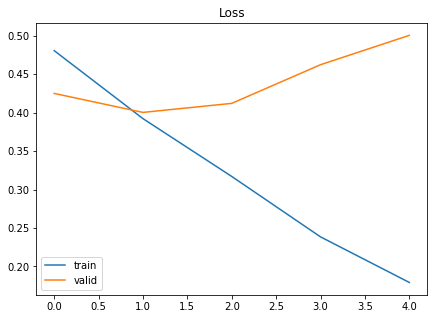

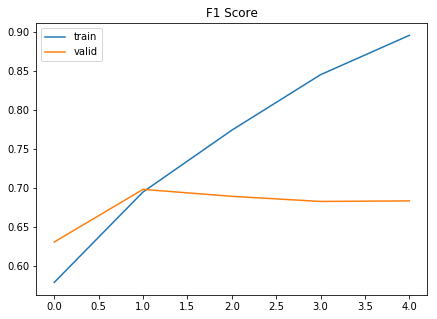

Best F1 score  [0.6977285963890507, 1]


In [ ]:
import matplotlib.pyplot as plt
import json
%matplotlib inline
with open(drive_path + 'model/seq_512_noise_0.15/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]
print(train_loss)
print(valid_loss)
plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))